In [1]:
!pip install numpy matplotlib seaborn scikit-learn tensorflow keras
!pip install keras-tuner --quiet
!pip install transformers datasets torchvision
!pip install tf-keras


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import os
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, InputLayer,
    Dense, Dropout, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.applications import EfficientNetB4

import keras_tuner as kt

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score
)
from sklearn.model_selection import train_test_split

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
with open("../data/processed/processed_full_dataset.pkl", "rb") as f:
    data = pickle.load(f)

X_train = data["X_train_bbox"]
y_train = data["y_train_bbox"]
X_val = data["X_val_bbox"]
y_val = data["y_val_bbox"]
X_test = data["X_test_bbox"]
y_test = data["y_test_bbox"]

all_breeds = sorted(np.unique(np.concatenate([y_train, y_val, y_test])))
print(f"Total breeds: {len(all_breeds)}")

breed_id_map = {breed: i for i, breed in enumerate(all_breeds)}
id_breed_map = {i: breed for breed, i in breed_id_map.items()}

y_train = np.array([breed_id_map[x] for x in y_train])
y_val = np.array([breed_id_map[x] for x in y_val])
y_test = np.array([breed_id_map[x] for x in y_test])

Total breeds: 120


In [4]:
print("Class distribution check:")
print(f"Train classes: {len(np.unique(y_train))}")
print(f"Val classes: {len(np.unique(y_val))}")
print(f"Test classes: {len(np.unique(y_test))}")
print(f"Train samples per class (min/max): {np.bincount(y_train).min()}/{np.bincount(y_train).max()}")


Class distribution check:
Train classes: 120
Val classes: 120
Test classes: 120
Train samples per class (min/max): 100/100


In [21]:
# setup
num_classes = len(all_breeds)
batch_size = 64

# data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.Lambda(lambda x: tf.image.random_brightness(x, max_delta=0.15)),
    tf.keras.layers.RandomContrast(0.15),
])

def preprocess_and_augment(x, y):
    x = tf.cast(x, tf.float32)
    x = tf.image.resize(x, (64, 64))
    x = data_augmentation(x, training=True)
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    return x, y

def preprocess_only(x, y):
    x = tf.cast(x, tf.float32)
    x = tf.image.resize(x, (64, 64))
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    return x, y

# datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
    .shuffle(5000) \
    .map(preprocess_and_augment, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(batch_size) \
    .prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)) \
    .map(preprocess_only, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(batch_size) \
    .prefetch(tf.data.AUTOTUNE)

# model
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(64, 64, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# f1 callback
class F1Callback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.best_f1 = 0.0
        from datetime import datetime
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
    def on_epoch_end(self, epoch, logs=None):
        # calculate f1
        from sklearn.metrics import f1_score
        val_predictions = self.model.predict(val_ds, verbose=0)
        val_pred_classes = np.argmax(val_predictions, axis=1)
        f1 = f1_score(y_val, val_pred_classes, average='macro', zero_division=0)
        
        # save if better
        if f1 > self.best_f1:
            self.best_f1 = f1
            self.model.save(f'best_f1_model_{self.timestamp}.keras')
            print(f'epoch {epoch+1}: new best f1 = {f1:.4f} - saved model')
        else:
            print(f'epoch {epoch+1}: f1 = {f1:.4f} (best: {self.best_f1:.4f})')

# callbacks
f1_callback = F1Callback()
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=1e-8)

# train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=35,
    callbacks=[f1_callback, early_stop, reduce_lr],
    verbose=1
)

# final results
print("\n=== FINAL RESULTS ===")
print(f"best f1 score: {f1_callback.best_f1:.4f}")
print(f"final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"best model saved as: best_f1_model_{f1_callback.timestamp}.keras")

# final f1 based on best model
from sklearn.metrics import f1_score
val_predictions = model.predict(val_ds, verbose=0)
val_pred_classes = np.argmax(val_predictions, axis=1)
final_f1_macro = f1_score(y_val, val_pred_classes, average='macro', zero_division=0)
final_f1_weighted = f1_score(y_val, val_pred_classes, average='weighted', zero_division=0)
final_accuracy = np.mean(y_val == val_pred_classes)

print(f"\nfinal validation metrics:")
print(f"  accuracy: {final_accuracy:.4f}")
print(f"  f1 macro: {final_f1_macro:.4f}")
print(f"  f1 weighted: {final_f1_weighted:.4f}")

Epoch 1/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.0084 - loss: 4.9663epoch 1: new best f1 = 0.0001 - saved model
188/188 ━━━━━━━━━━━━━━━━━━━━ 58s 246ms/step - accuracy: 0.0084 - loss: 4.9657 - val_accuracy: 0.0082 - val_loss: 5.0654 - learning_rate: 0.0010
Epoch 2/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.0303 - loss: 4.5826epoch 2: new best f1 = 0.0005 - saved model
188/188 ━━━━━━━━━━━━━━━━━━━━ 47s 248ms/step - accuracy: 0.0304 - loss: 4.5820 - val_accuracy: 0.0107 - val_loss: 4.9418 - learning_rate: 0.0010
Epoch 3/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.0573 - loss: 4.1734epoch 3: new best f1 = 0.0011 - saved model
188/188 ━━━━━━━━━━━━━━━━━━━━ 46s 245ms/step - accuracy: 0.0574 - loss: 4.1731 - val_accuracy: 0.0091 - val_loss: 5.9123 - learning_rate: 0.0010
Epoch 4/35
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.0894 - loss: 3.8497epoch 4: f1 = 0.0001 (best: 0.0011)
188/188 ━━━━━━━━━━━━━━━━━━━━ 47s 247ms/step - accura

In [22]:
# load the newest model
import os
model_files = [f for f in os.listdir('.') if f.startswith('best_f1_model_') and f.endswith('.keras')]
if model_files:
    newest_model = sorted(model_files)[-1]
    model = tf.keras.models.load_model(newest_model)
    print(f"loaded: {newest_model}")

# prepare validation data (same as training)
def preprocess_only(x, y):
    x = tf.cast(x, tf.float32)
    x = tf.image.resize(x, (64, 64))
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    return x, y

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)) \
    .map(preprocess_only, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(64) \
    .prefetch(tf.data.AUTOTUNE)

# get predictions
val_predictions = model.predict(val_ds, verbose=0)
val_pred_classes = np.argmax(val_predictions, axis=1)

# calculate metrics
from sklearn.metrics import f1_score, accuracy_score
accuracy = accuracy_score(y_val, val_pred_classes)
f1_macro = f1_score(y_val, val_pred_classes, average='macro', zero_division=0)
f1_weighted = f1_score(y_val, val_pred_classes, average='weighted', zero_division=0)

print(f"\nvalidation results:")
print(f"  accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)")
print(f"  f1 macro: {f1_macro:.4f}")
print(f"  f1 weighted: {f1_weighted:.4f}")

random_baseline = 1 / len(np.unique(y_val))
improvement = f1_macro / random_baseline
print(f"  improvement over random: {improvement:.1f}x")

loaded: best_f1_model_20250805_200742.keras

validation results:
  accuracy: 0.2723 (27.2%)
  f1 macro: 0.2474
  f1 weighted: 0.2598
  improvement over random: 29.7x


In [ ]:
# load best model
import os
model_files = [f for f in os.listdir('.') if f.startswith('best_f1_model_') and f.endswith('.keras')]
if model_files:
    newest_model = sorted(model_files)[-1]
    model = tf.keras.models.load_model(newest_model)
    print(f"loaded: {newest_model}")
else:
    print("no best_f1_model found")

# prepare test dataset
def preprocess_only(x, y):
    x = tf.cast(x, tf.float32)
    x = tf.image.resize(x, (64, 64))
    x = tf.keras.applications.efficientnet.preprocess_input(x)
    return x, y

# create test dataset
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)) \
    .map(preprocess_only, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(64) \
    .prefetch(tf.data.AUTOTUNE)

# get test predictions
test_predictions = model.predict(test_ds, verbose=0)
test_pred_classes = np.argmax(test_predictions, axis=1)

# calculate test metrics
from sklearn.metrics import f1_score, accuracy_score
test_accuracy = accuracy_score(y_test, test_pred_classes)
test_f1_macro = f1_score(y_test, test_pred_classes, average='macro', zero_division=0)
test_f1_weighted = f1_score(y_test, test_pred_classes, average='weighted', zero_division=0)

print(f"\n=== TEST RESULTS ===")
print(f"test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")
print(f"test f1 macro: {test_f1_macro:.4f}")
print(f"test f1 weighted: {test_f1_weighted:.4f}")

# compare with validation results
print(f"\n=== COMPARISON ===")
print(f"validation accuracy: {final_accuracy:.4f}")
print(f"test accuracy: {test_accuracy:.4f}")
print(f"difference: {abs(test_accuracy - final_accuracy):.4f}")

if abs(test_accuracy - final_accuracy) < 0.03:
    print("good generalization - test and val accuracy are close")
else:
    print("potential overfitting - test accuracy differs significantly from validation")

loaded: best_f1_model_20250805_133732.keras

=== TEST RESULTS ===
test accuracy: 0.3082 (30.8%)
test f1 macro: 0.2825
test f1 weighted: 0.2984

=== COMPARISON ===
validation accuracy: 0.3193
test accuracy: 0.3082
difference: 0.0112
good generalization - test and val accuracy are close


In [ ]:
# predict dog breed
model = tf.keras.models.load_model('FINAL_BEST_MODEL_F1.keras')

def predict_simple(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(64, 64))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.cast(img_array, tf.float32)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array, verbose=0)
    probs = predictions[0]
    
    # Get top 3 predictions
    top_3 = np.argsort(probs)[-3:][::-1]
    
    return [(idx, probs[idx]*100) for idx in top_3]

images = [
    "jenny_dog_resized.jpg",
    "lyn_dog_resized.jpg", 
    "ryan_cat_resized.jpg",
    "rodney_dog_resized.png"
]

# predict each image
for i, img_path in enumerate(images, 1):
    try:
        results = predict_simple(img_path)
        print(f"\n{i}. {img_path}:")
        for rank, (breed_id, confidence) in enumerate(results, 1):
            # Use breed names if available, otherwise breed ID
            breed_name = all_breeds[breed_id] if 'all_breeds' in locals() and breed_id < len(all_breeds) else f"Breed_{breed_id}"
            print(f"   {rank}. {breed_name}: {confidence:.1f}%")
    except Exception as e:
        print(f"{i}. {img_path}: Error - {e}")

print("\n✅ Done!")


1. jenny_dog_resized.jpg:
   1. toy_poodle: 100.0%
   2. miniature_poodle: 0.0%
   3. yorkshire_terrier: 0.0%

2. lyn_dog_resized.jpg:
   1. airedale: 100.0%
   2. bloodhound: 0.0%
   3. gordon_setter: 0.0%

3. ryan_cat_resized.jpg:
   1. sealyham_terrier: 100.0%
   2. yorkshire_terrier: 0.0%
   3. chihuahua: 0.0%

4. rodney_dog_resized.png:
   1. boxer: 100.0%
   2. pug: 0.0%
   3. bull_mastiff: 0.0%

✅ Done!


plotting training history...


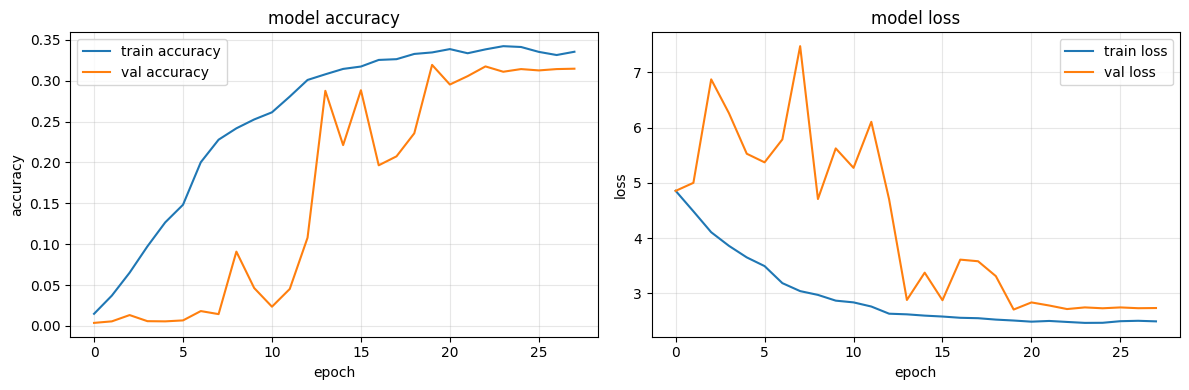

training plots saved as: training_history.png

final training metrics:
  final train accuracy: 0.3354
  final val accuracy: 0.3147
  final train loss: 2.4950
  final val loss: 2.7362
  best f1 score: 0.2919


In [ ]:
print("plotting training history...")

# check if history exists from recent training
if 'history' in locals() and history is not None:
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # accuracy plot
    axes[0].plot(history.history['accuracy'], label='train accuracy')
    axes[0].plot(history.history['val_accuracy'], label='val accuracy')
    axes[0].set_title('model accuracy')
    axes[0].set_xlabel('epoch')
    axes[0].set_ylabel('accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # loss plot
    axes[1].plot(history.history['loss'], label='train loss')
    axes[1].plot(history.history['val_loss'], label='val loss')
    axes[1].set_title('model loss')
    axes[1].set_xlabel('epoch')
    axes[1].set_ylabel('loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("training plots saved as: training_history.png")
    
    # print final metrics
    print(f"\nfinal training metrics:")
    print(f"  final train accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"  final val accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"  final train loss: {history.history['loss'][-1]:.4f}")
    print(f"  final val loss: {history.history['val_loss'][-1]:.4f}")
    if hasattr(f1_callback, 'best_f1'):
        print(f"  best f1 score: {f1_callback.best_f1:.4f}")

else:
    print("no training history available (need to run training first)")

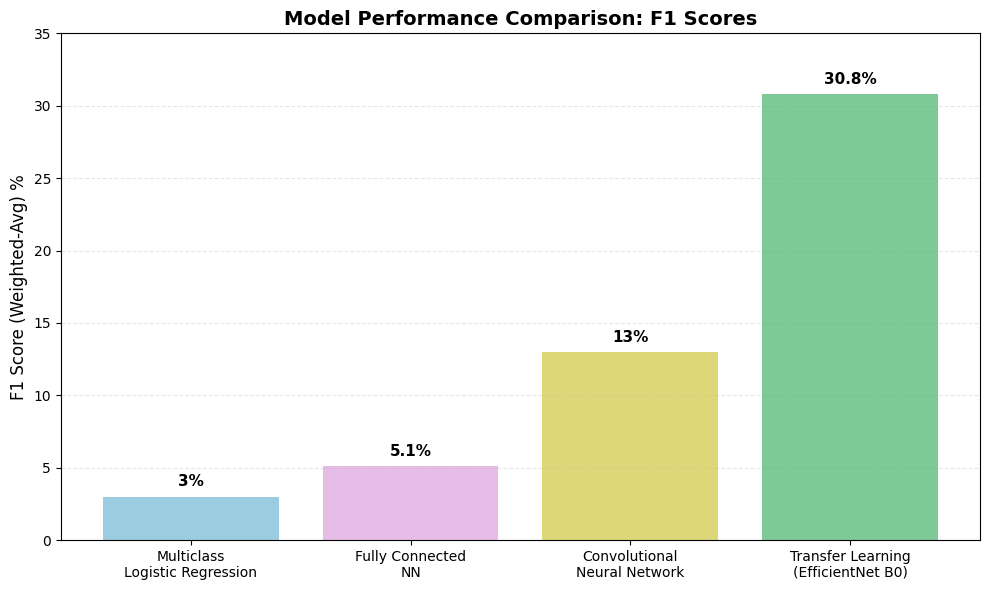

Model Performance Summary:
Multiclass Logistic Regression: 3%
Fully Connected NN: 5.1%
Convolutional Neural Network: 13%
Transfer Learning (EfficientNet B0): 30.8%

Improvement from baseline:
Transfer Learning vs Logistic Regression: 10.3x better
Transfer Learning vs CNN: 2.4x better


In [ ]:
# F1 Score Comparison Chart

# data from the other models
models = ['Multiclass\nLogistic Regression', 'Fully Connected\nNN', 'Convolutional\nNeural Network', 'Transfer Learning\n(EfficientNet B0)']
f1_scores = [3, 5.10, 13, 30.8] 

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(models, f1_scores, color=["#72B7D3", '#DDA0DD', "#D0C642", "#48B46A"], alpha=0.7)

ax.set_ylabel('F1 Score (Weighted-Avg) %', fontsize=12)
ax.set_title('Model Performance Comparison: F1 Scores', fontsize=14, fontweight='bold')
ax.set_ylim(0, 35)

for bar, score in zip(bars, f1_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{score}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.xticks(rotation=0, ha='center')
plt.tight_layout()

plt.show()

print("Model Performance Summary:")
print("=" * 50)
for model, score in zip(models, f1_scores):
    print(f"{model.replace(chr(10), ' ')}: {score}%")
print("\nImprovement from baseline:")
print(f"Transfer Learning vs Logistic Regression: {f1_scores[-1]/f1_scores[0]:.1f}x better")
print(f"Transfer Learning vs CNN: {f1_scores[-1]/f1_scores[2]:.1f}x better")